# GAN Train

Train on synthethic data, test on real data.

### Imports

In [9]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, random_split, TensorDataset
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os

### Data preprocessing

In [10]:
gan_data = torch.load('cgan_bce\CGAN_BCE_data.pth')
gan_labels = torch.load('cgan_bce\CGAN_BCE_labels.pth')
print(gan_data.size())
print(gan_labels.size())

gan_dataset = TensorDataset(gan_data, gan_labels)

# Split into train and validation sets - 80:20
train_size = int(0.8 * len(gan_dataset))
val_size = len(gan_dataset) - train_size
train_dataset, val_dataset = random_split(gan_dataset, [train_size, val_size])

# DataLoader for batching
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)

torch.Size([904, 50, 30])
torch.Size([904])


In [11]:
real_data = torch.load('data_mm_user1.pth')
real_labels = torch.load('labels_user1.pth')

# Normalize it to fall in range[-1, 1]
min_val = real_data.min()
max_val = real_data.max()
real_data = 2 * ((real_data - min_val) / (max_val - min_val)) - 1

real_test_dataset = TensorDataset(real_data, real_labels)
test_loader = DataLoader(real_test_dataset, batch_size=32, shuffle=False)


### CNN

In [12]:
class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, padding=1)
        self.batch_norm1 = nn.BatchNorm2d(32)
        self.batch_norm2 = nn.BatchNorm2d(64)
        self.batch_norm3 = nn.BatchNorm2d(128)
        self.pool = nn.MaxPool2d(2, 2)
        self.dropout = nn.Dropout(0.3)
        self.fc1 = nn.Linear(128 * 6 * 3, 8)

    def forward(self, x):
        x = self.pool(torch.relu(self.batch_norm1(self.conv1(x))))
        x = self.dropout(x)
        x = self.pool(torch.relu(self.batch_norm2(self.conv2(x))))
        x = self.dropout(x)
        x = self.pool(torch.relu(self.batch_norm3(self.conv3(x))))
        x = self.dropout(x)
        x = x.view(-1, 128 * 6 * 3)
        x = self.fc1(x)
        return x

### Training

In [13]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
model = CNN().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Train the model
epochs = 40
patience = 3
best_val_loss = np.inf
train_losses, val_losses, train_accuracies, val_accuracies = [], [], [], []

for epoch in range(epochs):
    model.train()
    running_train_loss = 0.0
    correct_train = 0
    total_train = 0
    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(images.unsqueeze(1).float())
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_train_loss += loss.item()
        _, preds = torch.max(outputs, 1)
        correct_train += (preds == labels).sum().item()
        total_train += labels.size(0)

    train_loss = running_train_loss / len(train_loader)
    train_accuracy = correct_train / total_train
    train_losses.append(train_loss)
    train_accuracies.append(train_accuracy)

    model.eval()
    running_val_loss = 0.0
    correct_val = 0
    total_val = 0
    
    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images.unsqueeze(1).float())
            loss = criterion(outputs, labels)
            running_val_loss += loss.item()
            _, preds = torch.max(outputs, 1)
            correct_val += (preds == labels).sum().item()
            total_val += labels.size(0)

    val_loss = running_val_loss / len(val_loader)
    val_accuracy = correct_val / total_val
    val_losses.append(val_loss)
    val_accuracies.append(val_accuracy)

    print(f"Epoch {epoch+1}/{epochs} - Train Loss: {train_loss:.4f}, Train Accuracy: {train_accuracy:.4f}, "
          f"Val Loss: {val_loss:.4f}, Val Accuracy: {val_accuracy:.4f}")
    
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        torch.save(model.state_dict(), "gan_train_results/best_cnn_model.pth")
        early_stop_counter = 0
    else:
        early_stop_counter += 1
        if early_stop_counter >= patience:
            print("Early stopping triggered.")
            break

Epoch 1/40 - Train Loss: 1.7986, Train Accuracy: 0.3707, Val Loss: 1.8695, Val Accuracy: 0.2873
Epoch 2/40 - Train Loss: 1.2235, Train Accuracy: 0.6210, Val Loss: 1.2724, Val Accuracy: 0.5691
Epoch 3/40 - Train Loss: 0.8996, Train Accuracy: 0.7455, Val Loss: 0.9866, Val Accuracy: 0.6464
Epoch 4/40 - Train Loss: 0.7990, Train Accuracy: 0.7427, Val Loss: 0.8695, Val Accuracy: 0.6961
Epoch 5/40 - Train Loss: 0.6686, Train Accuracy: 0.7925, Val Loss: 0.6351, Val Accuracy: 0.7403
Epoch 6/40 - Train Loss: 0.5919, Train Accuracy: 0.8147, Val Loss: 0.6707, Val Accuracy: 0.7569
Epoch 7/40 - Train Loss: 0.5263, Train Accuracy: 0.8160, Val Loss: 0.5216, Val Accuracy: 0.8011
Epoch 8/40 - Train Loss: 0.4780, Train Accuracy: 0.8340, Val Loss: 0.6040, Val Accuracy: 0.7901
Epoch 9/40 - Train Loss: 0.5258, Train Accuracy: 0.8271, Val Loss: 0.6109, Val Accuracy: 0.7845
Epoch 10/40 - Train Loss: 0.4790, Train Accuracy: 0.8271, Val Loss: 0.5655, Val Accuracy: 0.7956
Early stopping triggered.


### Evaluating on real data

In [14]:
def accuracy_score(actual, pred):
    actual_tensor = torch.tensor(actual)
    pred_tensor = torch.tensor(pred)
    total = len(actual_tensor)
    correct = (actual_tensor == pred_tensor).sum().item()
    return correct / total

# Load the best model for evaluation on test data
model.load_state_dict(torch.load("gan_train_results/best_cnn_model.pth"))
model.eval()
test_labels = []
test_preds = []
with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images.unsqueeze(1).float())
        _, preds = torch.max(outputs, 1)
        test_labels.extend(labels.cpu().numpy())
        test_preds.extend(preds.cpu().numpy())

test_accuracy = accuracy_score(test_labels, test_preds)
print(f"GAN Train Score: {test_accuracy:.4f}")


print('==========================================================================================================')



GAN Train Score: 0.1561


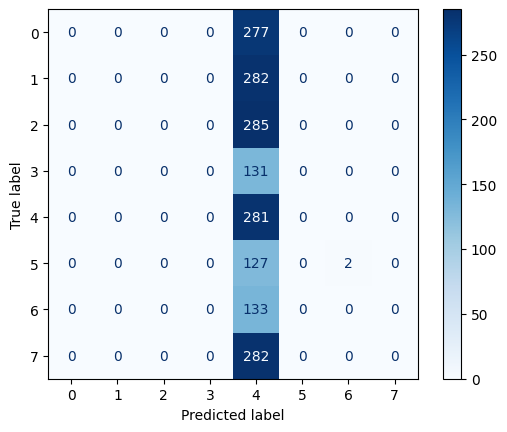

In [15]:
cm = confusion_matrix(test_labels, test_preds)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap='Blues')
plt.savefig("gan_train_results/confusion_matrix.png")
plt.show()

Classification Report:


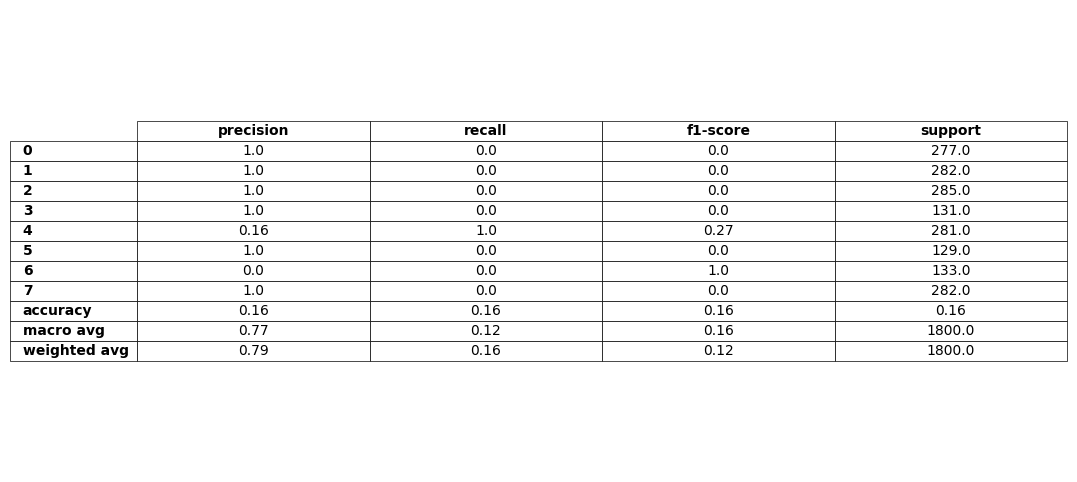

In [16]:
class_report = classification_report(test_labels, test_preds, output_dict=True, zero_division=1)
print("Classification Report:")
df_class_report = pd.DataFrame(class_report).transpose().round(2)
fig, ax = plt.subplots(figsize=(10, 6))
ax.axis('off')
table = ax.table(cellText=df_class_report.values, colLabels=df_class_report.columns, rowLabels=df_class_report.index,
                 cellLoc='center', loc='center')
table.auto_set_font_size(False)
table.set_fontsize(10)
table.scale(1.2, 1.2)
for key, cell in table.get_celld().items():
    cell.set_linewidth(0.5)
    cell.set_text_props(fontweight='bold' if key[0] == 0 or key[1] == -1 else 'normal')
plt.savefig("gan_train_results/classification_report.png")
plt.show()